In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
from numba import cuda
from scipy.stats import poisson
import scipy
import numba
import time
import multiprocessing as mp
import matplotlib.font_manager as font_manager
import sys
from tqdm import tqdm

In [2]:
@jit(nopython = True)
def decide_interact_neuron_square(neuron_row, neuron_column, neuron_number_row, neuron_number_column):
    if (neuron_row - 1 < 0):
        left = [neuron_number_row -1, neuron_column]
    else:
        left = [neuron_row - 1, neuron_column]
    
    if (neuron_row + 1 == neuron_number_row):
        right = [0, neuron_column]
    else:
        right = [neuron_row + 1, neuron_column]
        
    if (neuron_column + 1 == neuron_number_column):
        up = [neuron_row, 0]
    else:
        up = [neuron_row, neuron_column + 1]
        
    if (neuron_column - 1 < 0):
        down = [neuron_row, neuron_number_column -1]
    else:
        down = [neuron_row, neuron_column - 1]
        
    return np.array([left, down, right, up])

@jit(nopython = True)
def create_square_lattice_link(row_number, column_number, sigma):
    square_lattice = np.zeros((row_number, column_number, 4, 2))
    p_max = 2*sigma/4
    flag = np.zeros((row_number, column_number , 4))
    link = np.zeros((row_number, column_number, 4))
    for row in range(row_number):
        for column in range(column_number):
            square_lattice[row][column][:] = decide_interact_neuron_square(row, column, row_number, column_number)[:]
            for i in range(4):
                if (flag[row][column][i] == 0):
                    random = p_max/2
                    # random = np.random.random() * p_max
                    link[row][column][i] = random
                    r, c = square_lattice[row][column][i]
                    link[int(r)][int(c)][int((i+2)%4)] = random
                    flag[row][column][i] = 1
                    flag[int(r)][int(c)][int((i+2)%4)] = 1
                    
    ###   break the periodic structure   ###
#     for c in range (column_number):
#         link[0][c][0] = 0
#         link[row_number - 1][c][2] = 0
#     for r in range (row_number):
#         link[r][0][1] = 0
#         link[r][column_number - 1][3] = 0
    return square_lattice, link

In [3]:
###   external stimulus   ###
@jit(nopython = True)
def external_arr(t_min, t_max, t, r):
    if t_min <= t < t_max:
        return (1 - np.exp(-r))
    else:
        return np.zeros(r.shape)
    
###   internal(neural) stimulus   ###
@jit(nopython = True)
def internal_arr(p, index_matrix, state_matrix, state_number, degree):
    probability = np.zeros((state_matrix.shape))
    for row in range(state_matrix.shape[0]):
        for column in range(state_matrix.shape[1]):
            for i in range (int(degree[row][column])) :
                r, c = index_matrix[row][column][i]
#                 if (state_matrix[int(r)][int(c)] == 1):
                if (state_matrix[int(r)][int(c)] ==(state_number - 1) ):
                    probability[row][column] = 1 - (1 - p[row][column][i]) * (1 - probability[row][column])
    return probability


###   determine the activity   ###
@jit(nopython = True)
def rho_determine(state_matrix, state_number):
    row_number = state_matrix.shape[0]
    column_number = state_matrix.shape[1]
    fire = 0
    for row in range(row_number):
#         active = [i for i, v in enumerate(state_matrix[row]) if v==1]
        active = [i for i, v in enumerate(state_matrix[row]) if v == (state_number - 1)]
        fire += len(active)
#     print(fire)
    return fire/(state_matrix.shape[0]*state_matrix.shape[1])

###   determine the average activity   ###
@jit(nopython = True)
def F0_determine(rho, T_min = 0, T_max = 1000):
    return rho[T_min:T_max].sum()/rho[T_min:T_max].size

In [4]:
@jit(nopython = True)
def KC_model_extinction(degree, index_matrix, p, t_min, stimulas_t, stimulas_S, MC_times, state_number, ensemble_n):#, noise_r = 0):

    ###   Initialization   ###
    row_number = p.shape[0]
    column_number = p.shape[1]
    extinction_time = np.zeros(ensemble_n)
    
    ###   conduct the ensemble   ###
    for e in range(ensemble_n):
        
        ###   Initialization   ###
        state_matrix = np.random.randint(0, state_number, (row_number, column_number))
        rho = rho_determine(state_matrix, state_number)
        temp = np.copy(state_matrix)
        t = 0
        
        ###   Monte Carlo simulation (stop while activity is zero(extinction))   ###
        while((t<MC_times) & (rho != 0)):
            t += 1
            internal = internal_arr(p, index_matrix, state_matrix, state_number, degree)
            for r in range (row_number):
                temp[r][np.where((state_matrix[r]>0)&(state_matrix[r]<(state_number)))] -= 1 
                
                ###   Locate the excitable neurons   ###
                location_0 = np.where(state_matrix[r] == 0)
                probability[location_0] = 1 -  ((1 - internal[r][location_0]) * \
                                                (1 - external_arr(t_min, stimulas_t, t, stimulas_S[r][location_0])))
                
                 ###   determine the process from resting to firing   ###
                random = np.random.random(column_number)
                probability = np.zeros(column_number)
                temp[r][np.where(random < probability)] = state_number - 1
                
            state_matrix = np.copy(temp)
            rho = rho_determine(state_matrix, state_number)
        extinction_time[e] = t
    return extinction_time

In [5]:
###   Initialization   ###
@jit(nopython = True)
def extinction_test(L, sigma):
    row = int(L)
    column = int(L)
    states_num = 6
    times = 2000
    ensemble_times = 5000
    degree = np.ones((row, column))*4
    degree_clone = degree.copy()
    network_connection, p  = create_square_lattice_link(row,column,sigma)
    r = 0.0
    r_array = np.ones((row, column)) * r 
    extinction = KC_model_extinction(degree, network_connection, p, 0, 800, r_array, times, states_num, ensemble_times)
    return extinction

###   Muti-core   ###
@jit(nopython = True)
def multi_compute_extinction_test(L_state_number):
    L, sigma = L_state_number[0], L_state_number[1]
    extinction_result = extinction_test(L, sigma)
    print(sigma, 'finished')
    return extinction_result

In [6]:
pool = mp.Pool(processes = 6)
test_banch = np.array([[128, 1.6 + 0.02*i] for i in range(6)])
start_i = time.time()
test_result_PBC = pool.map(multi_compute_extinction_test, test_banch)
print('Time cost:', time.time()-start_i)

Time cost: 2034.1834139823914


In [15]:
test_result_OBC = np.load('KCNN_extinction_test_L128_OBC_e5000.npy')   ### load data for open boundary condition
test_result_PBC = np.load('KCNN_extinction_test_L128_PBC_e5000.npy')   ### load data for periodic boundary condition

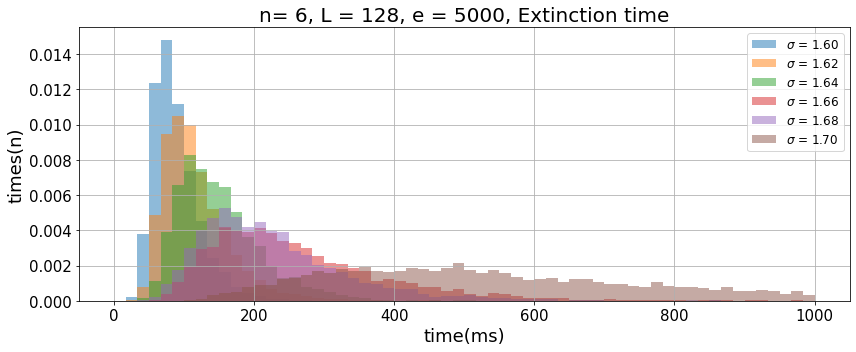

In [16]:
fig, ax = plt.subplots(figsize=(12, 5))
for sigma in range(6):
    ax.hist(test_result_PBC[sigma], bins = 60, range = (0, 1000), alpha = 0.5, \
            label = '$\sigma$ = %.2f'%(1.6 + 0.02*sigma), density = 1)
    
ax.set_xlabel('time(ms)',fontsize=18)
ax.set_ylabel('times(n)',fontsize=18)
ax.set_title('n= %d, L = %d, e = %d, Extinction time'%(6, 128, 5000),fontsize=20)
# ax.set_yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
font_prop = font_manager.FontProperties(size=12)
ax.legend(prop = font_prop)
fig.tight_layout()
plt.grid()